<a href="https://colab.research.google.com/github/ttashatss/fitnessevaluation/blob/main/pose-estimation-model-optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
! git clone https://github.com/microsoft/human-pose-estimation.pytorch && cd human-pose-estimation.pytorch && git checkout 18f1d0fa5b5db7fe08de640610f3fdbdbed8fb2f

fatal: destination path 'human-pose-estimation.pytorch' already exists and is not an empty directory.


In [22]:
! pip install onnx onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.4 MB/s eta 0:00:00


In [8]:
import sys
if "/content/human-pose-estimation.pytorch/lib/" not in sys.path:
  sys.path.insert(0, "/content/human-pose-estimation.pytorch/lib/")

In [9]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.transforms as T
from torchsummary import summary
import cv2
import re
import os
import copy
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import models
from core.config import config
from core.config import update_config
from core.config import update_dir
from core.config import get_model_name
from core.config import *

Choose pre-trained model to use - ResNet50

In [10]:
CONFIG_FILE = '/content/human-pose-estimation.pytorch/experiments/mpii/resnet50/256x256_d256x3_adam_lr1e-3.yaml'
MODEL_PATH = '/content/drive/MyDrive/pose_mpii/pose_resnet_50_256x256.pth.tar'

In [11]:
model = eval('models.'+config.MODEL.NAME+'.get_pose_net')(config, is_train=False)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

Perform image transformation in order to input into the model for joint detection

In [12]:
transform = T.Compose([
                       T.Resize((256, 256)),
                       T.ToTensor(), 
                       T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                       ])

# to tensor: convert numpy array or PIL image into a tensor format - the form of (C*H*W)
# normalize: take a tensor image and normalize it with mean and standard deviation

image = Image.open('/content/human-pose-estimation.pytorch/pose_estimation/squat.jpg')
tr_img = transform(image)

output = model(tr_img.unsqueeze(0))
output = output.squeeze(0)

_, OUT_HEIGHT, OUT_WIDTH = output.shape
print(f'output shape: {output.shape}')

# helper function we will use later
get_detached = lambda x: copy.deepcopy(x.cpu().detach().numpy())

POSE_PAIRS = [[9, 8],[8, 7],[7, 6],[6, 2],[2, 1],[1, 0],[6, 3],[3, 4],[4, 5],[7, 12],[12, 11],[11, 10],[7, 13],[13, 14],[14, 15]]

from operator import itemgetter
get_keypoints = lambda pose_layers: map(itemgetter(1, 3), [cv2.minMaxLoc(pose_layer) for pose_layer in pose_layers])

JOINTS = ['0 - r ankle', '1 - r knee', '2 - r hip', '3 - l hip', '4 - l knee', '5 - l ankle', '6 - pelvis', '7 - thorax', '8 - upper neck', '9 - head top', '10 - r wrist', '11 - r elbow', '12 - r shoulder', '13 - l shoulder', '14 - l elbow', '15 - l wrist']
JOINTS = [re.sub(r'[0-9]+|-', '', joint).strip().replace(' ', '-') for joint in JOINTS]

output shape: torch.Size([16, 64, 64])


Visualizing the body joints

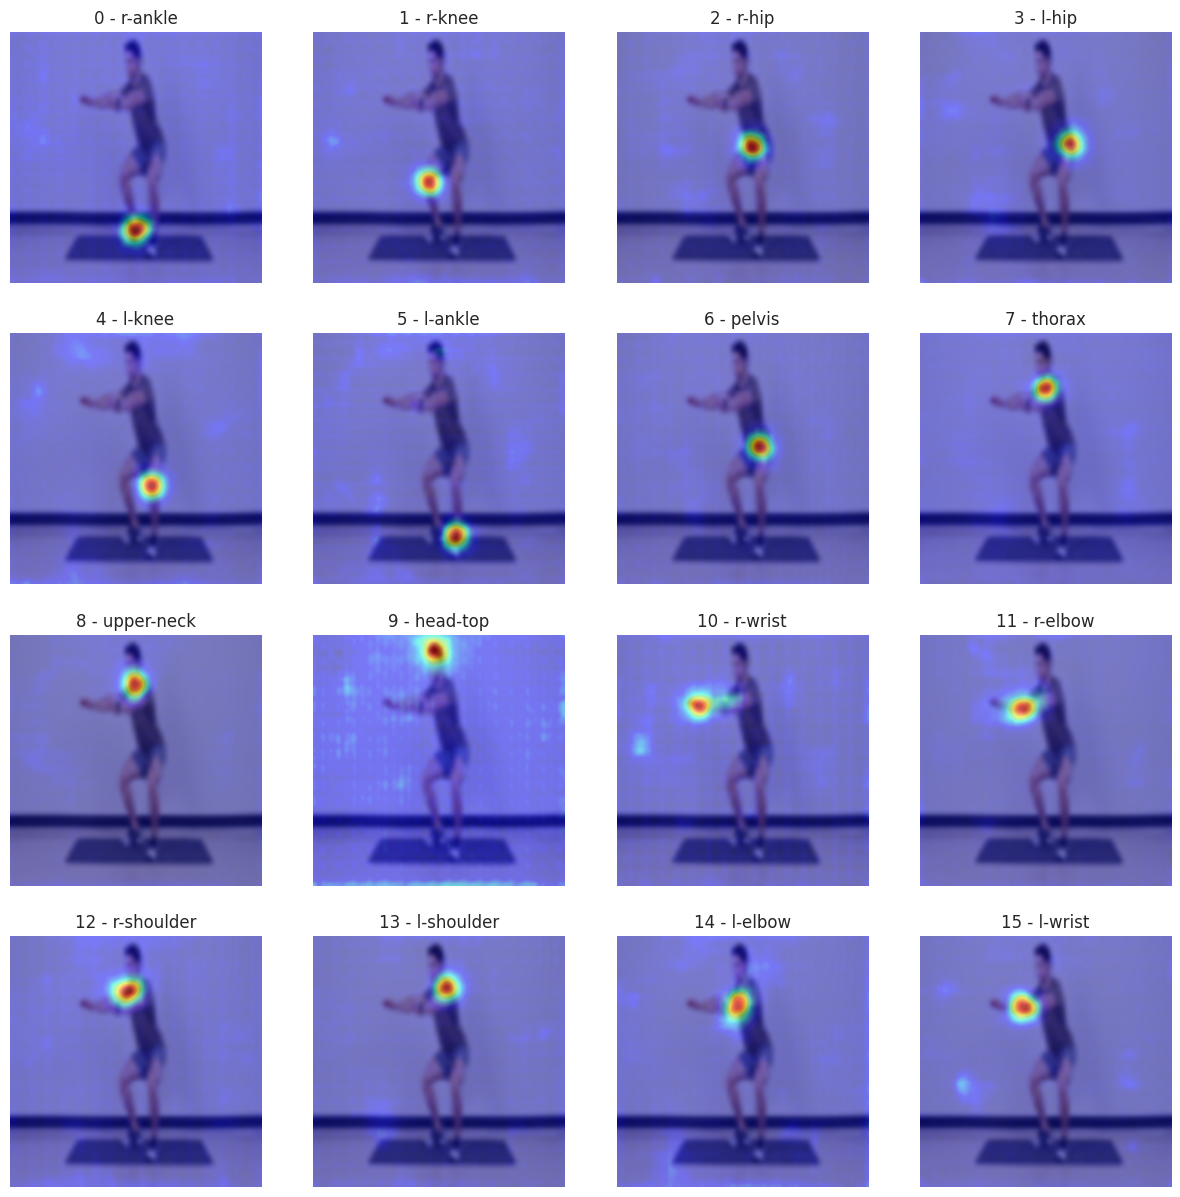

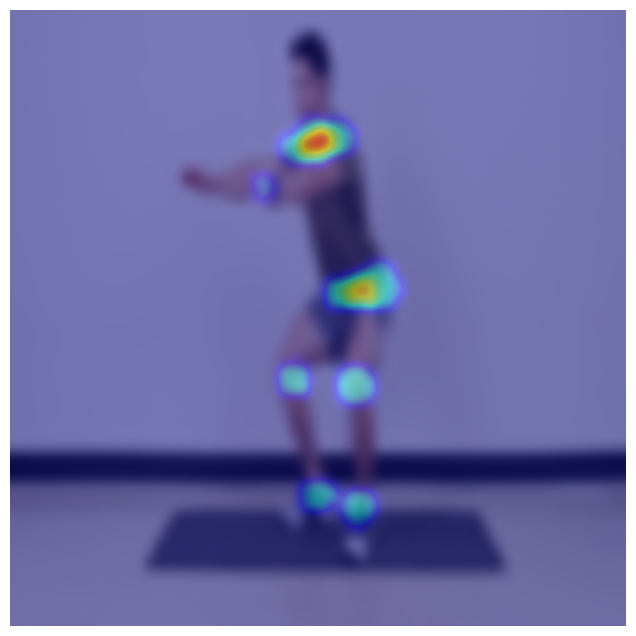

In [13]:
plt.figure(figsize=(15, 15))
for idx, pose_layer in enumerate(get_detached(output)):
    # print(pose_layer.shape)
    plt.subplot(4, 4, idx + 1)
    plt.title(f'{idx} - {JOINTS[idx]}')
    plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
    plt.imshow(pose_layer, alpha=0.5, cmap='jet', interpolation='bicubic')
    plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
pose_layers = get_detached(output)
pose_layers = np.clip(pose_layers, 0.7, 1.0)
layer_sum = np.sum(pose_layers, axis=0)
plt.imshow(layer_sum, alpha=0.5, cmap='jet', interpolation='bicubic')
plt.axis('off')
plt.show()

In [14]:
img_src = cv2.imread('/content/human-pose-estimation.pytorch/pose_estimation/squat.jpg',0)
print(img_src)

[[229 229 229 ... 225 225 225]
 [229 229 229 ... 225 225 225]
 [229 229 229 ... 225 225 225]
 ...
 [218 217 217 ... 217 219 220]
 [224 223 221 ... 215 215 215]
 [224 223 221 ... 215 215 215]]


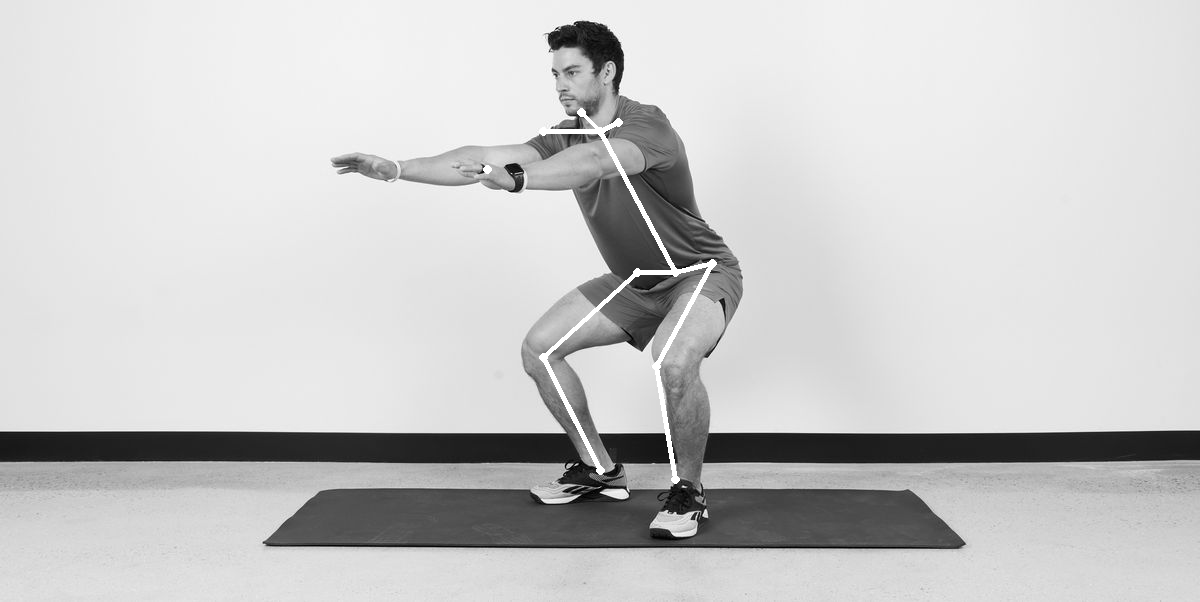

In [15]:
THRESHOLD = 0.8
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_p = img_src
pose_layers = get_detached(x=output)
key_points = list(get_keypoints(pose_layers=pose_layers))
is_joint_plotted = [False for i in range(len(JOINTS))]
for pose_pair in POSE_PAIRS:
    from_j, to_j = pose_pair

    from_thr, (from_x_j, from_y_j) = key_points[from_j]
    to_thr, (to_x_j, to_y_j) = key_points[to_j]

    IMG_HEIGHT, IMG_WIDTH = image_p.shape

    from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
    from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

    from_x_j, to_x_j = int(from_x_j), int(to_x_j)
    from_y_j, to_y_j = int(from_y_j), int(to_y_j)

    if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
        # this is a joint
        cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[from_j] = True

    if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
        # this is a joint
        cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[to_j] = True

    if from_thr > THRESHOLD and to_thr > THRESHOLD:
        # this is a joint connection, plot a line
        cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 3)
        
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_GRAY2RGB))


Model Summary

In [16]:
# Model summary of the original input image
summary(model, (3, 602, 1200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 301, 600]           9,408
       BatchNorm2d-2         [-1, 64, 301, 600]             128
              ReLU-3         [-1, 64, 301, 600]               0
         MaxPool2d-4         [-1, 64, 151, 300]               0
            Conv2d-5         [-1, 64, 151, 300]           4,096
       BatchNorm2d-6         [-1, 64, 151, 300]             128
              ReLU-7         [-1, 64, 151, 300]               0
            Conv2d-8         [-1, 64, 151, 300]          36,864
       BatchNorm2d-9         [-1, 64, 151, 300]             128
             ReLU-10         [-1, 64, 151, 300]               0
           Conv2d-11        [-1, 256, 151, 300]          16,384
      BatchNorm2d-12        [-1, 256, 151, 300]             512
           Conv2d-13        [-1, 256, 151, 300]          16,384
      BatchNorm2d-14        [-1, 256, 1

In [17]:
# Model summary of the resized input image
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

Model optimization with ONNX

The optimization uses ONNX Runtime native library to rewrite the computation graph, including merging computation nodes, eliminating redundancies to improve runtime efficiency.

We choose ONNX because for PyTorch quantization, only a few models can be quantized (ex. LSTM, BERT) or else, further modifications have to be done

In [18]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

def print_size_of_onnx_model(model):
    onnx.save(model, 'temp.onnx')
    print('Size (MB):', os.path.getsize("temp.onnx")/1e6)
    os.remove('temp.onnx')

In [19]:
# The current size of teh model
print_size_of_model(model)

Size (MB): 136.303329


In [26]:
import io
import numpy as np
import torch.onnx

# Converting pyTorch model to ONNX model

# Input to the model
torch_model = model
batch_size = 1
x = torch.randn(batch_size, 3, 256, 256, requires_grad=True)
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "/content/human-pose-estimation.pytorch/pose_estimation/simple_pose_estimation.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

import onnx

onnx_model = onnx.load("/content/human-pose-estimation.pytorch/pose_estimation/simple_pose_estimation.onnx")
onnx.checker.check_model(onnx_model)

print_size_of_onnx_model(onnx_model)

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Size (MB): 135.924938


In [27]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

model_fp32 = '/content/human-pose-estimation.pytorch/pose_estimation/simple_pose_estimation.onnx'
model_quant = 'path/to/the/model.quant.onnx'
quantized_model = quantize_dynamic(model_fp32, model_quant)

FileNotFoundError: ignored

In [32]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

quantize_dynamic(
    '/content/human-pose-estimation.pytorch/pose_estimation/simple_pose_estimation.onnx',
    "onnx-quantized/model-int8.onnx",
    weight_type=QuantType.QUInt8,
    use_external_data_format=True
)

FileNotFoundError: ignored